# Задача №6. Исполнитель Филатов Андрей

Повторить эксперимент WANN: провести эволюционную процедуру построения нейросети для выборки MNIST. При построении эволюционного алгоритма ограничиться одним скрытым слоем константными значениями параметров "1", "-1".

Source code: https://github.com/SirBob01/NEAT-Python  
Good explanation of NEAT method https://www.youtube.com/watch?v=VMQOa4-rVxE

### Part I. Importing useful packages

In [93]:
import random
import pickle
import copy
import itertools
import math
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Resize
from sklearn.model_selection import StratifiedShuffleSplit

import seaborn as sns; sns.set(style='whitegrid')

In [233]:
def stable_softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(1, keepdims=True)

def cross_entropy(X,y):
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    	Note that y is not one-hot encoded vector. 
    	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """
    m = y.shape[0]
    p = stable_softmax(X)
    # We use multidimensional array indexing to extract 
    # softmax probability of the correct label for each sample.
    # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
    log_likelihood = -np.log(p[range(m),y], dtype=np.float16)
    loss = np.sum(log_likelihood, dtype=np.float16) / m
    return loss

### Part II. Making dataset

Here, we are using 1000 samples from MNIST to train our WANN model. According the paper we reduce size of MNIST images to (16, 16)

In [94]:
train_dataset = MNIST('', download=True)
split = StratifiedShuffleSplit(n_splits=10, test_size=0.0167)

train_idx, test_idx = next(split.split(range(60000), train_dataset.targets))
train_dataset.data = train_dataset.data[test_idx]
train_dataset.targets = train_dataset.targets[test_idx]

train_dataset.data = F.interpolate(train_dataset.data.unsqueeze(1), size=(16, 16)).reshape(-1, 256).float().numpy().astype(np.float16)
y = train_dataset.targets.numpy()

### Part III. Defining Net class

`Brain` is a collection of Species  
`Species` is a collection of Genome (our  Neural Networks). We split Genomes on Species using genome distance function.  
`Genome` is a graph defining some neural network.

In [101]:
def sigmoid(x):
    return 1/(1 + np.exp(-x, dtype=np.float16))

class Edge(object):
    """A gene object representing an edge in the neural network."""
    def __init__(self, weight):
        self.weight = weight
        self.enabled = True

class Node(object):
    """A gene object representing a node in the neural network."""
    def __init__(self, activation):
        self.output = 0
        self.bias = 0.0
        self.activation = activation

def genomic_distance(a, b, distance_weights):
    """Calculate the genomic distance between two genomes."""
    a_edges = set(a._edges)
    b_edges = set(b._edges)

    # Does not distinguish between disjoint and excess
    matching_edges = a_edges & b_edges
    disjoint_edges = (a_edges - b_edges) | (b_edges - a_edges)
    N_edges = len(max(a_edges, b_edges, key=len))
    N_nodes = min(a._max_node, b._max_node)

    weight_diff = 0.0
    for i in matching_edges:
        weight_diff += abs(a._edges[i].weight - b._edges[i].weight)

    bias_diff = 0.0
    for i in range(N_nodes):
        bias_diff += abs(a._nodes[i].bias - b._nodes[i].bias)

    t1 = distance_weights['edge'] * len(disjoint_edges)/N_edges
    t2 = distance_weights['weight'] * weight_diff/len(matching_edges)
    t3 = distance_weights['bias'] * bias_diff/N_nodes
    return t1 + t2 + t3

def genomic_crossover(a, b):
    """Breed two genomes and return the child. Matching genes
    are inherited randomly, while disjoint genes are inherited
    from the fitter parent.
    """
    # Template genome for child
    child = Genome(a._inputs, a._outputs, a._default_activation)
    a_in = set(a._edges)
    b_in = set(b._edges)

    # Inherit homologous gene from a random parent
    for i in a_in & b_in:
        parent = random.choice([a, b])
        child._edges[i] = copy.deepcopy(parent._edges[i])

    # Inherit disjoint/excess genes from fitter parent
    if a._fitness > b._fitness:
        for i in a_in - b_in:
            child._edges[i] = copy.deepcopy(a._edges[i])
    else:
        for i in b_in - a_in:
            child._edges[i] = copy.deepcopy(b._edges[i])
    
    # Calculate max node
    child._max_node = 0
    for (i, j) in child._edges:
        current_max = max(i, j)
        child._max_node = max(child._max_node, current_max)
    child._max_node += 1

    # Inherit nodes
    for n in range(child._max_node):
        inherit_from = []
        if n in a._nodes:
            inherit_from.append(a)
        if n in b._nodes:
            inherit_from.append(b)

        random.shuffle(inherit_from)
        parent = max(inherit_from, key=lambda p: p._fitness)
        child._nodes[n] = copy.deepcopy(parent._nodes[n])

    child.reset()
    return child


class Hyperparameters(object):
    """Hyperparameter settings for the Brain object."""
    def __init__(self):
        self.delta_threshold = 1.5
        self.distance_weights = {
            'edge' : 1.0,
            'weight' : 1.0,
            'bias' : 1.0
        }
        self.default_activation = torch.sigmoid

        self.max_fitness = float('inf')
        self.max_generations = float('inf')
        self.max_fitness_history = 30

        self.breed_probabilities = {
            'asexual' : 0.5,
            'sexual' : 0.5
        }
        self.mutation_probabilities = {
            'node' : 0.3,
            'edge' : 0.3,
            'weight_pertub' : 0.2,
            'bias_pertub' : 0.2
        }

In [199]:
class Genome(object):
    """Base class for a standard genome used by the NEAT algorithm."""
    def __init__(self, inputs, outputs, default_activation):
        # Nodes
        self._inputs = inputs
        self._outputs = outputs

        self._unhidden = inputs+outputs
        self._max_node = inputs+outputs

        # Structure
        self._edges = {} # (i, j) : Edge
        self._nodes = {} # NodeID : Node

        self._default_activation = default_activation

        # Performance
        self._fitness = 0.0
        self._adjusted_fitness = 0.0

    def generate(self):
        """Generate the neural network of this genome with minimal
        initial topology, i.e. (no hidden nodes). Call on genome
        creation.
        """
        # Minimum initial topology, no hidden layer
        for n in range(self._max_node):
            self._nodes[n] = Node(self._default_activation)

        for i in range(self._inputs):
            for j in range(self._inputs, self._unhidden):
                self.add_edge(i, j, np.random.randint(2) * 2 - 1)

    def add_edge(self, i, j, weight):
        """Add a new connection between existing nodes."""
        if (i, j) in self._edges:
            self._edges[(i, j)].enabled = True
        else:
            self._edges[(i, j)] = Edge(weight)

    def forward(self, inputs):
        """Evaluate inputs and calculate the outputs of the
        neural network via the forward propagation algorithm.
        """

        # Set input values
        for i in range(self._inputs):
            self._nodes[i].output = inputs[:, i]
        
        # Generate backward-adjacency list 
        _from = {}
        for n in range(self._max_node):
            _from[n] = []

        for (i, j) in self._edges:
            if not self._edges[(i, j)].enabled:
                continue
            _from[j].append(i)

        # Calculate output values for each node
        ordered_nodes = itertools.chain(
            range(self._unhidden, self._max_node),
            range(self._inputs, self._unhidden)
        )
        for j in ordered_nodes:
            ax = 0
            for i in _from[j]:
                ax += self._edges[(i, j)].weight * self._nodes[i].output

            node = self._nodes[j]
            node.output = node.activation(ax + node.bias)
        
        return [self._nodes[n].output for n in range(self._inputs, self._unhidden)]
    
    def mutate(self, probabilities):
        """Randomly mutate the genome to initiate variation."""
        if self.is_disabled():
            self.add_enabled()

        population = list(probabilities.keys())
        weights = [probabilities[k] for k in population]
        choice = random.choices(population, weights=weights)[0]

        if choice == "node":
            self.add_node()
        elif choice == "edge":
            (i, j) = self.random_pair()
            self.add_edge(i, j, np.random.randint(2) * 2 - 1)
        elif choice == "weight_perturb" or choice == "weight_set":
            self.shift_weight(choice)
        elif choice == "bias_perturb" or choice == "bias_set":
            self.shift_bias(choice)

        self.reset()

    def add_node(self):
        """Add a new node between a randomly selected edge,
        disabling the parent edge.
        """
        enabled = [k for k in self._edges if self._edges[k].enabled]
        (i, j) = random.choice(enabled)
        edge = self._edges[(i, j)]
        edge.enabled = False

        new_node = self._max_node
        self._max_node += 1
        self._nodes[new_node] = Node(self._default_activation)

        self.add_edge(i, new_node, 1)
        self.add_edge(new_node, j, edge.weight)

    def add_edge(self, i, j, weight):
        """Add a new connection between existing nodes."""
        if (i, j) in self._edges:
            self._edges[(i, j)].enabled = True
        else:
            self._edges[(i, j)] = Edge(weight)
            
    def add_enabled(self):
        """Re-enable a random disabled edge."""
        disabled = [e for e in self._edges if not self._edges[e].enabled]

        if len(disabled) > 0:
            self._edges[random.choice(disabled)].enabled = True
        
    def shift_weight(self, type):
        """Randomly shift, perturb, or set one of the edge weights."""
        e = random.choice(list(self._edges.keys()))
        if type == "weight_perturb":
            self._edges[e].weight = np.random.randint(2) * 2 - 1

    def shift_bias(self, type):
        """Randomly shift, perturb, or set the bias of an incoming edge."""
        # Select only nodes in the hidden and output layer
        n = random.choice(range(self._inputs, self._max_node))
        if type == "bias_perturb":
            self._nodes[n].bias = np.random.randint(2) * 2 - 1

    def random_pair(self):
        """Generate random nodes (i, j) such that:
        1. i is not an output
        2. j is not an input
        3. i != j
        """
        i = random.choice([n for n in range(self._max_node) if not self.is_output(n)])
        j_list = [n for n in range(self._max_node) if not self.is_input(n) and n != i]

        if not j_list:
            j = self._max_node
            self.add_node()
        else:
            j = random.choice(j_list)

        return (i, j)

    def is_input(self, n):
        """Determine if the node id is an input."""
        return 0 <= n < self._inputs

    def is_output(self, n):
        """Determine if the node id is an output."""
        return self._inputs <= n < self._unhidden

    def is_hidden(self, n):
        """Determine if the node id is hidden."""
        return self._unhidden <= n < self._max_node

    def is_disabled(self):
        """Determine if all of its genes are disabled."""
        return all(self._edges[i].enabled == False for i in self._edges)

    def get_fitness(self):
        """Return the fitness of the genome."""
        return self._fitness

    def get_nodes(self):
        """Get the nodes of the network."""
        return self._nodes.copy()

    def get_edges(self):
        """Get the network's edges."""
        return self._edges.copy()

    def get_num_nodes(self):
        """Get the number of nodes in the network."""
        return self._max_node

    def set_fitness(self, score):
        """Set the fitness score of this genome."""
        self._fitness = score

    def reset(self):
        """Reset the genome's internal state."""
        for n in range(self._max_node):
            self._nodes[n].output = 0
        self._fitness = 0.0

    def clone(self):
        """Return a clone of the genome.
        """
        return copy.deepcopy(self)

In [200]:
class Specie(object):
    """A specie represents a set of genomes whose genomic distances 
    between them fall under the Brain's delta threshold.
    """
    def __init__(self, max_fitness_history, *members):
        self._members = list(members)
        self._fitness_history = []
        self._fitness_sum = 0
        self._max_fitness_history = max_fitness_history

    def breed(self, mutation_probabilities, breed_probabilities):
        """Return a child as a result of either a mutated clone
        or crossover between two parent genomes.
        """
        # Either mutate a clone or breed two random genomes
        population = list(breed_probabilities.keys())
        probabilities= [breed_probabilities[k] for k in population]
        choice = random.choices(population, weights=probabilities)[0]

        if choice == "asexual" or len(self._members) == 1:
            child = random.choice(self._members).clone()
            child.mutate(mutation_probabilities)
        elif choice == "sexual":
            (mom, dad) = random.sample(self._members, 2)
            child = genomic_crossover(mom, dad)

        return child

    def update_fitness(self):
        """Update the adjusted fitness values of each genome 
        and the historical fitness."""
        for g in self._members:
            g._adjusted_fitness = g._fitness/len(self._members)

        self._fitness_sum = sum([g._adjusted_fitness for g in self._members])
        self._fitness_history.append(self._fitness_sum)
        if len(self._fitness_history) > self._max_fitness_history:
            self._fitness_history.pop(0)

    def cull_genomes(self, fittest_only):
        """Exterminate the weakest genomes per specie."""
        self._members.sort(key=lambda g: g._fitness, reverse=True)
        if fittest_only:
            # Only keep the winning genome
            remaining = 1
        else:
            # Keep top 25%
            remaining = int(math.ceil(0.25*len(self._members)))

        self._members = self._members[:remaining]

    def get_best(self):
        """Get the member with the highest fitness score."""
        return max(self._members, key=lambda g: g._fitness)

    def can_progress(self):
        """Determine whether species should survive the culling."""
        n = len(self._fitness_history)
        avg = sum(self._fitness_history) / n
        return avg > self._fitness_history[0] or n < self._max_fitness_history

In [201]:
class Brain(object):
    """Base class for a 'brain' that learns through the evolution
    of a population of genomes.
    """
    def __init__(self, inputs, outputs, population=100, hyperparams=Hyperparameters()):
        self._inputs = inputs
        self._outputs = outputs

        self._species = []
        self._population = population

        # Hyper-parameters
        self._hyperparams = hyperparams
        
        self._generation = 0
        self._current_species = 0
        self._current_genome = 0

        self._global_best = None

    def generate(self):
        """Generate the initial population of genomes."""
        for i in range(self._population):
            g = Genome(self._inputs, self._outputs, 
                       self._hyperparams.default_activation)
            g.generate()
            self.classify_genome(g)
        
        # Set the initial best genome
        self._global_best = self._species[0]._members[0]

    def classify_genome(self, genome):
        """Classify genomes into species via the genomic
        distance algorithm.
        """
        if not self._species:
            # Empty population
            self._species.append(Specie(
                    self._hyperparams.max_fitness_history, genome
                )
            )
        else:
            # Compare genome against representative s[0] in each specie
            for s in self._species:
                rep =  s._members[0]
                dist = genomic_distance(
                    genome, rep, self._hyperparams.distance_weights
                )
                if dist <= self._hyperparams.delta_threshold:
                    s._members.append(genome)
                    return

            # Doesn't fit with any other specie, create a new one
            self._species.append(Specie(
                    self._hyperparams.max_fitness_history, genome
                )
            )

    def update_fittest(self):
        """Update the highest fitness score of the whole population."""
        top_performers = [s.get_best() for s in self._species]
        current_top = max(top_performers, key=lambda g: g._fitness)

        if current_top._fitness > self._global_best._fitness:
            self._global_best = current_top.clone()

    def evolve(self):
        """Evolve the population by eliminating the poorest performing
        genomes and repopulating with mutated children, prioritizing
        the most promising species.
        """
        global_fitness_sum = 0
        for s in self._species:
            s.update_fitness()
            global_fitness_sum += s._fitness_sum

        if global_fitness_sum == 0:
            # No progress, mutate everybody
            for s in self._species:
                for g in s._members:
                    g.mutate(self._hyperparams.mutation_probabilities)
        else:
            # Only keep the species with potential to improve
            surviving_species = []
            for s in self._species:
                if s.can_progress():
                    surviving_species.append(s)
            self._species = surviving_species

            # Eliminate lowest performing genomes per specie
            for s in self._species:
                s.cull_genomes(False)

            # Repopulate
            for i, s in enumerate(self._species):
                ratio = s._fitness_sum/global_fitness_sum
                diff = self._population - self.get_population()
                offspring = int(round(ratio * diff))
                for j in range(offspring):
                    self.classify_genome(
                        s.breed(
                            self._hyperparams.mutation_probabilities, 
                            self._hyperparams.breed_probabilities
                        )
                    )

            # No species survived
            # Repopulate using mutated minimal structures and global best
            if not self._species:
                for i in range(self._population):
                    if i%3 == 0:
                        g = self._global_best.clone()
                    else:
                        g = Genome(self._inputs, self._outputs, 
                                   self._hyperparams.default_activation)
                        g.generate()
                    g.mutate(self._hyperparams.mutation_probabilities)
                    self.classify_genome(g)

        self._generation += 1

    def should_evolve(self):
        """Determine if the system should continue to evolve
        based on the maximum fitness and generation count.
        """
        self.update_fittest()
        fit = self._global_best._fitness <= self._hyperparams.max_fitness
        end = self._generation != self._hyperparams.max_generations

        return fit and end

    def next_iteration(self):
        """Call after every evaluation of individual genomes to
        progress training.
        """
        s = self._species[self._current_species]
        if self._current_genome < len(s._members)-1:
            self._current_genome += 1
        else:
            if self._current_species < len(self._species)-1:
                self._current_species += 1
                self._current_genome = 0
            else:
                # Evolve to the next generation
                self.evolve()
                self._current_species = 0
                self._current_genome = 0

    def evaluate_parallel(self, evaluator, *args, **kwargs):
        """Evaluate the entire population on separate processes
        to progress training. The evaluator function must take a Genome
        as its first parameter and return a numerical fitness score.
        Any global state passed to the evaluator is copied and will not
        be modified at the parent process.
        """
        max_proc = max(mp.cpu_count()-1, 1)
        pool = mp.Pool(processes=max_proc)
        
        results = {}
        for i in range(len(self._species)):
            for j in range(len(self._species[i]._members)):
                results[(i, j)] = pool.apply_async(
                    evaluator, 
                    args=[self._species[i]._members[j]]+list(args), 
                    kwds=kwargs
                )

        for key in results:
            genome = self._species[key[0]]._members[key[1]]
            genome.set_fitness(results[key].get())

        pool.close()
        pool.join()
        self.evolve()

    def get_fittest(self):
        """Return the genome with the highest global fitness score."""
        return self._global_best

    def get_population(self):
        """Return the true (calculated) population size."""
        return sum([len(s._members) for s in self._species])

    def get_current(self):
        """Get the current genome for evaluation."""
        s = self._species[self._current_species]
        return s._members[self._current_genome]

    def get_current_species(self):
        """Get index of current species being evaluated."""
        return self._current_species

    def get_current_genome(self):
        """Get index of current genome being evaluated."""
        return self._current_genome

    def get_generation(self):
        """Get the current generation number of this population."""
        return self._generation

    def get_species(self):
        """Get the list of species and their respective member genomes."""
        return self._species

    def save(self, filename):
        """Save an instance of the population to disk."""
        with open(filename+'.neat', 'wb') as _out:
            pickle.dump(self, _out, pickle.HIGHEST_PROTOCOL)

    @staticmethod
    def load(filename):
        """Return an instance of a population from disk."""
        with open(filename+'.neat', 'rb') as _in:
            return pickle.load(_in)

### Part IV. Experiments

In original paper they change **weights**, **connections**, **nodes** and **activation** functions. In our experiment we only change the first three. Weights can be 1 or -1. Mutation probabilities are described in `Hyperparameters`

In [202]:
hp = Hyperparameters()
hp.default_activation = sigmoid
hp.max_generations = 10000

Generating population of neural networks

In [203]:
# Takes 256 inputs, produces 10 outputs
brain = Brain(256, 10, population=100, hyperparams=hp)
brain.generate()

Starting training

In [207]:
i = 0
avg_fitness = []
best_fitness = []
while brain.should_evolve():
    genome = brain.get_current()
    pred = np.stack(genome.forward(train_dataset.data), 1)
    fitness = -cross_entropy(pred, y) + 5
    genome.set_fitness(fitness) # score() returns a numerical fitness value
    
    brain.next_iteration() # Next genome to be evaluated
    i += 1
    if i % 200 == 0:
        print(f"{i} Ineration", brain.get_fittest().get_fitness())
        res = [x.get_fitness() for x in brain.get_species()[0]._members if x.get_fitness() != 0.0]
        res.append(1e-7)
        avg_fitness.append(np.mean(res))
        best_fitness.append(brain.get_fittest().get_fitness())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


200 Ineration 2.7604790419161676
400 Ineration 2.7724550898203595
600 Ineration 2.8243512974051894
800 Ineration 2.8622754491017965
1000 Ineration 2.8842315369261478
1200 Ineration 2.914171656686627
1400 Ineration 2.9301397205588824
1600 Ineration 2.940119760479042
1800 Ineration 2.9570858283433132
2000 Ineration 2.9770459081836327
2200 Ineration 2.9830339321357284
2400 Ineration 2.997005988023952
2600 Ineration 3.007984031936128
2800 Ineration 3.0099800399201597
3000 Ineration 3.0189620758483033
3200 Ineration 3.023952095808383
3400 Ineration 3.0309381237524953
3600 Ineration 3.034930139720559
3800 Ineration 3.035928143712575
4000 Ineration 3.039920159680639
4200 Ineration 3.0429141716566868
4400 Ineration 3.0459081836327346
4600 Ineration 3.0479041916167664
4800 Ineration 3.0508982035928143
5000 Ineration 3.0538922155688626
5200 Ineration 3.055888223552894
5400 Ineration 3.0568862275449105
5600 Ineration 3.0598802395209583
5800 Ineration 3.060878243512974
6000 Ineration 3.06187624750

KeyboardInterrupt: ignored

Let's plot *fitness* function = -loss + 5.0

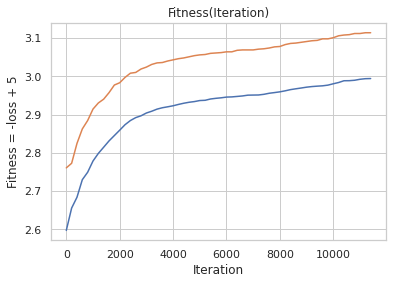

In [219]:
plt.plot(range(0, 11600, 200), avg_fitness, label='avg')
plt.plot(range(0, 11600, 200), best_fitness, label='best')

plt.xlabel('Iteration')
plt.ylabel('Fitness = -loss + 5')
plt.title('Fitness(Iteration)')
plt.show()

In [234]:
best_accuracy = (np.stack(brain.get_fittest().forward(train_dataset.data), axis=1).argmax(1) == y).mean()
print('Best model accuracy  =', best_accuracy)

Best model accuracy  = 0.43213572854291415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


### Part V. Conclusion

Модель, работает, но медленней стандартной нейронной сети.